# COVID-19 Lung Leision Segmentation

In [2]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

# append project directory to path
import sys
project_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_dir, "data")
model_dir = os.path.join(project_dir, "model")
sys.path.append(project_dir)
print(f"project directory: {project_dir}")
print(f"data directory: {data_dir}")
print(f"model directory: {model_dir}")

project directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation
data directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/data
model directory: /home/jinyijia/bme4460/Covid19_Leision_Segmentation/model


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# check gpu
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

# seeding
torch.manual_seed(4460)
np.random.seed(4460)

GPU available: True


In [36]:

class BasicDataset(TensorDataset):
    def __init__(self, folder, n_sample=None, transforms=None):
        """
        takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that folder.
        Also if you'd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
        """
        # loading
        self.folder = folder
        self.pairs_file = sorted(glob.glob(os.path.join(self.folder, '*.npy')))
                
        # sampling
        if not n_sample or n_sample > len(self.pairs_file):
            n_sample = len(self.pairs_file)
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])
          
        # transformations
        self.transforms = transforms
            
    def __len__(self):
        """return length of the dataset (AKA number of samples in that set)"""
        return self.n_sample
    
    def __getitem__(self, i):
        """
        takes: an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function)
        returns: grayscale image, mask (Binary), and the index of the file name (will use for visualization)
        The preprocessing step is also implemented in this function.
        """
        file_path = self.pairs_file[i]
        idx = self.ids[i]
        data = np.load(file_path, allow_pickle=True)

        img = data[0,:,:]
        mask = data[1,:,:]
        # show_pair(img, mask, idx)

        img = np.array(img * 255, dtype = np.uint8)
        
        # resize img
        img_size = 128
        img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA).astype('uint8')
        mask = cv2.resize(mask, (img_size, img_size), interpolation = cv2.INTER_AREA).astype('uint8')

        # S]dcale img between 0 to 1
        img = np.array(img) / 255.0
        
        # convert mask to binary
        mask[mask <= 0.5] = 0
        mask[mask > 0.5] = 1

        
        # add channel axis
        img = np.expand_dims(img, axis=-1)
        mask = np.expand_dims(mask, axis=-1)


        # any customized transforms
        if self.transforms:
            img = self.transforms(image=img, mask=mask)
                    
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.LongTensor),
            'img_id': idx
        }

In [37]:
# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = BasicDataset(os.path.join(data_dir, 'PairedTrainData'), n_sample=1000)
valid_dataset = BasicDataset(os.path.join(data_dir, 'PairedValidData'), n_sample=300)
test_dataset = BasicDataset(os.path.join(data_dir, 'PairedTestData'), n_sample=300)

train_dataloader = DataLoader(train_dataset, batch_size=1000, num_workers=4, pin_memory=True, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=300, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=300, num_workers=4, pin_memory=True)

In [38]:
for batch in train_dataloader:
    sample_batch = batch
    break
lung_train = sample_batch['image'].numpy()
infect_train = sample_batch['mask'].numpy()

for batch in valid_dataloader:
    sample_batch = batch
    break
lung_val = sample_batch['image'].numpy()
infect_val = sample_batch['mask'].numpy()


for batch in test_dataloader:
    sample_batch = batch
    break
lung_test = sample_batch['image'].numpy()
infect_test = sample_batch['mask'].numpy()

In [39]:
infect_val.shape

(300, 128, 128, 1)

In [40]:
import tensorflow as tf
from tensorflow.keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred):
    smooth = 0.0001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 1

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=, metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [41]:
history = model.fit(lung_train, infect_train, epochs = 10, validation_data = (lung_test, infect_test))

Epoch 1/10
32/32 [==============================] - 53s 2s/step - loss: 0.3072 - dice_coef: 0.0087 - binary_accuracy: 0.9652 - val_loss: 0.0772 - val_dice_coef: 0.0070 - val_binary_accuracy: 0.9877
Epoch 2/10
32/32 [==============================] - 53s 2s/step - loss: 0.0462 - dice_coef: 0.0291 - binary_accuracy: 0.9908 - val_loss: 0.0542 - val_dice_coef: 0.0488 - val_binary_accuracy: 0.9877
Epoch 3/10
32/32 [==============================] - 53s 2s/step - loss: 0.0411 - dice_coef: 0.0428 - binary_accuracy: 0.9908 - val_loss: 0.0562 - val_dice_coef: 0.0505 - val_binary_accuracy: 0.9877
Epoch 4/10
32/32 [==============================] - 52s 2s/step - loss: 0.0397 - dice_coef: 0.0482 - binary_accuracy: 0.9908 - val_loss: 0.0614 - val_dice_coef: 0.0502 - val_binary_accuracy: 0.9877
Epoch 5/10
32/32 [==============================] - 52s 2s/step - loss: 0.0393 - dice_coef: 0.0507 - binary_accuracy: 0.9908 - val_loss: 0.0518 - val_dice_coef: 0.0541 - val_binary_accuracy: 0.9877
Epoch 6/10

KeyboardInterrupt: 

<b> Load Full Datasets </b>

In [5]:
train_dataset = BasicDataset(os.path.join(data_dir, 'PairedTrainData'))
valid_dataset = BasicDataset(os.path.join(data_dir, 'PairedValidData'))
test_dataset = BasicDataset(os.path.join(data_dir, 'PairedTestData'))
len(train_dataset), len(valid_dataset), len(test_dataset)

(2910, 1467, 1197)

<b> Check Data Shape </b>

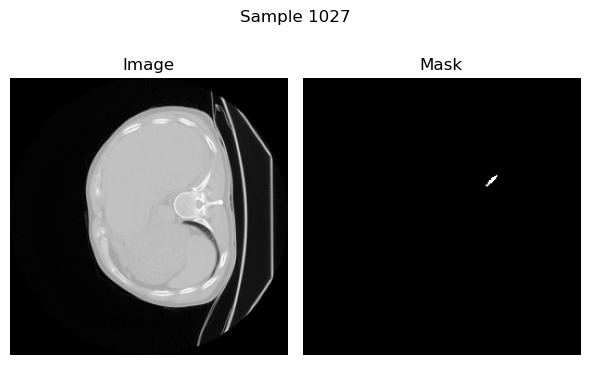

x shape: torch.Size([1, 256, 256])
y shape: torch.Size([256, 256])


In [7]:
from utils import show_pair

# show a random pair (CT image, infection mask)
sample_data = train_dataset[np.random.randint(0, len(train_dataset))]
x, y, idx = sample_data['image'], sample_data['mask'], sample_data['img_id']
show_pair(x[0], y, idx)
print(f'x shape: {x.shape}')
print(f'y shape: {y.shape}')


In [7]:
# describe image 
pd.DataFrame(x.flatten()).describe() # describe image 

,0
count,65536.000000
mean,0.262904
std,0.336328
min,0.000000
25%,0.007843
50%,0.023529
75%,0.721569
max,1.000000


In [8]:
# describe mask
pd.DataFrame(y.flatten()).describe() # describe image 

,0
count,65536.000000
mean,0.000549
std,0.023431
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<b> Show Data Split </b>

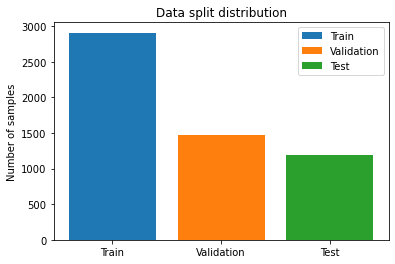

In [9]:
from utils import show_datasets

show_datasets(train_dataset, valid_dataset, test_dataset)

### Train

<b>Basic UNet-1024</b>

In [ ]:
from networks import UNet, UNet_Reduced
from run_network import get_total_params

# define model
my_UNet = UNet('MyUNet', 1, 2) # output classes = 2
my_UNet.cuda()
print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

<b>Reduced UNet-256</b>

In [1]:
from networks import UNet, UNet_Reduced
from run_network import get_total_params

my_UNet = UNet_Reduced('MyUNet_red_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

MyUNet_red_256 total model parameters: 1813218


In [2]:
my_UNet

UNet_Reduced(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.3, inplace=False)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.3, inplace=False)
          (4): Conv2d(32, 32, kernel_

<b>Attention U-Net</b>

In [7]:
from networks import AttU_Net
from run_network import get_total_params

my_UNet = AttU_Net('AttU_Net', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

AttU_Net total model parameters: 34877486


<b>ResU-Net++</b>

In [6]:
from networks import ResUnetPlusPlus
from run_network import get_total_params

my_UNet = ResUnetPlusPlus('ResUnetPlusPlus', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

ResUnetPlusPlus total model parameters: 14481445


In [ ]:
from networks import R2AttU_Net
from run_network import get_total_params

my_UNet = R2AttU_Net('MyUNet_red_256', 1, 2) # output classes = 2
my_UNet.cuda()

print(f"{my_UNet.name} total model parameters:", get_total_params(my_UNet))

In [8]:
# Re-create train, validation, and test dataset instances to reduce the number of samples and expedite the training process.
train_dataset = BasicDataset(os.path.join(data_dir, 'PairedTrainData'), n_sample=2000)
valid_dataset = BasicDataset(os.path.join(data_dir, 'PairedValidData'), n_sample=600)
test_dataset = BasicDataset(os.path.join(data_dir, 'PairedTestData'), n_sample=600)

train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4, pin_memory=True, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, num_workers=4, pin_memory=True)

<b>Initial Weights </b>

Although we have not trained our model, we may see the output with random weights. Thus, we will pull a batch of test data loader, get the network's output, and plot it.

Sample batch 'image 'shape is: torch.Size([16, 1, 256, 256])
Sample batch 'mask' shape is: torch.Size([16, 256, 256])
Predicted mask shape is: torch.Size([16, 2, 256, 256])


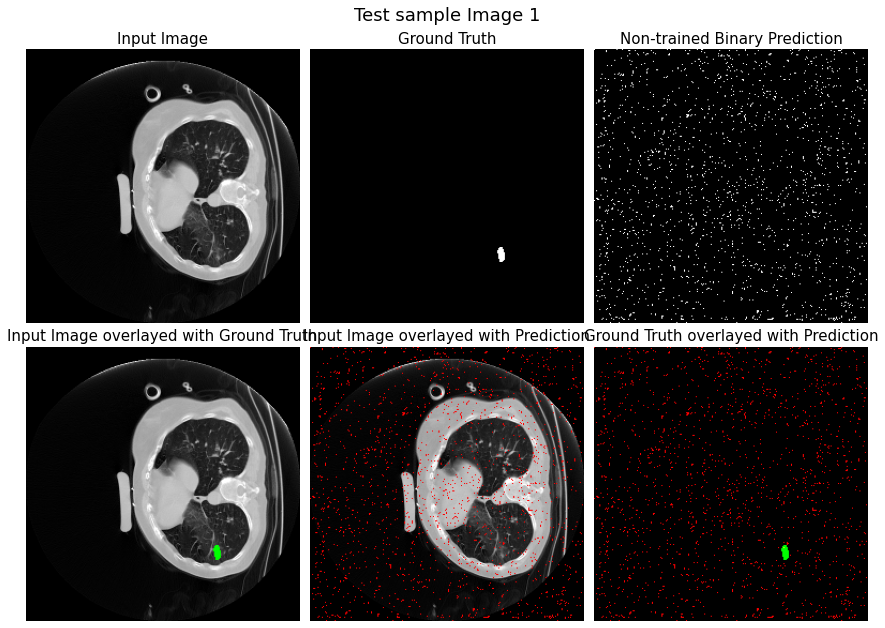

In [9]:
from utils import show_mask

show_mask(my_UNet, test_dataloader)

### 3. Train the model

In [10]:
from run_network import get_class_weight
# lr decay 
optimizer = torch.optim.Adam(my_UNet.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.5)

# use class weight for imbalanced data
class_weights = get_class_weight(train_dataset)
class_weights = torch.tensor([0.02, 1.], dtype=torch.float).cuda()
criteria = nn.CrossEntropyLoss(weight=class_weights)


In [11]:
from run_network import train_net

# train 
EPOCHS = 100
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, criteria, scheduler= lr_scheduler, save_dir = model_dir)

### Display results

In [ ]:
from run_network import show_training

show_training(EPOCHS, train_loss, valid_loss, train_dice, valid_dice, train_jaccard, valid_jaccard)

<b> Load Best Model </b>

Best epoch is epoch 185


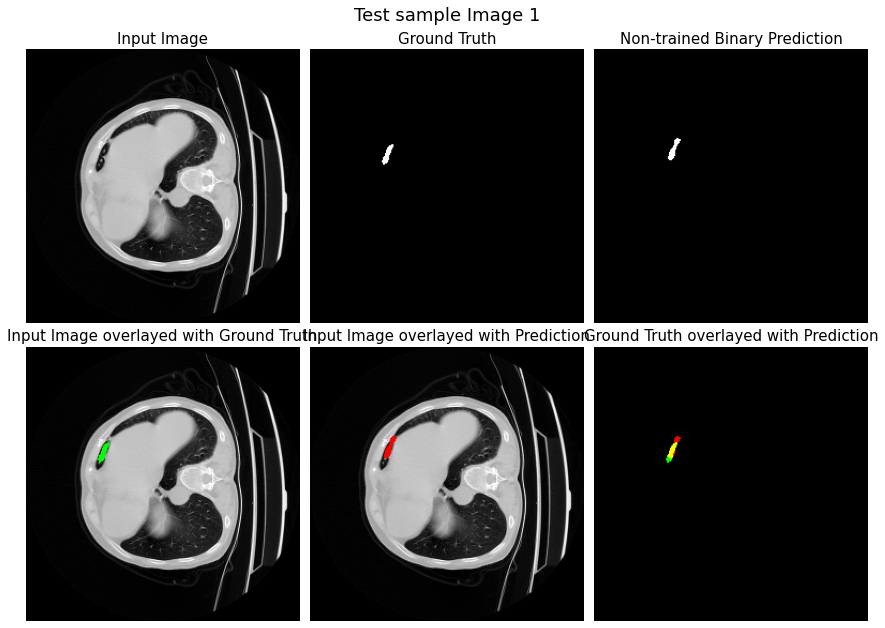

In [66]:
best_epoch = np.argmax(valid_dice) + 1 # epochs starts at 1
print(f'Best epoch is epoch {best_epoch}')

state_dict = torch.load(os.path.join(model_dir, my_UNet.name, f'epoch_{best_epoch:03}.pth'))

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

# check the performance of the best model on our previously pulled example
show_mask(my_UNet, valid_dataloader, verbose=False)

<b>Test Data </b>

In [26]:
# from run_network import test_net
# best_epoch = 80
# state_dict = torch.load(os.path.join(model_dir, my_UNet.name, f'epoch_{best_epoch:03}.pth'))

# my_UNet.load_state_dict(state_dict)
# my_UNet.cuda()

# run best model on testdata
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_UNet, test_dataloader, criteria, save_dir=model_dir)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')

Test Loss: 0.3894649876654148, Test DICE score: 0.5987473726272583, Test Jaccard score: 0.44473302364349365, Test overall accuracy: 0.9905220031738281


Text(0.5, 69.0, 'predicted labels')

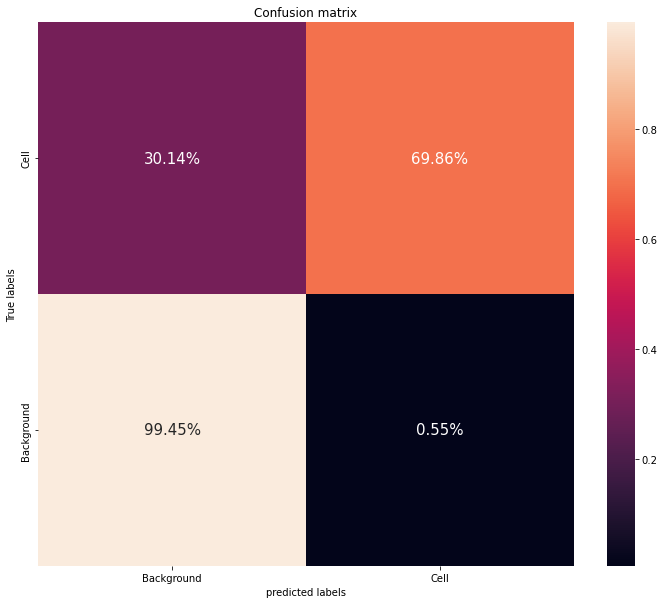

In [27]:
# confusion matrix
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (12,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2])
plt.ylabel('True labels')
plt.xlabel('predicted labels')